In [25]:
#coding=gbk
import math
import random
import matplotlib.pyplot as plt
import time
import numpy as np
from decimal import *
getcontext().prec=36

class T_kernel_SGD():
    def __init__(self,d,s):
        self.d = d
        self.s = s
        self.Tn = [np.array([1.])]
        self.K_n = [[np.array([0.])]]
        self.K_t = [[ np.array([1.]) ]]
        self.L_n = 0
        self.fn = [[np.array([0.])]]
        self.f_average_n = [[np.array([0.])]]
        self.computing_ploy = []
        self.gamma0 = 1 #Initial step size
        self.t = 0 #Step decay rate
        self.epoch = 1 #  Current number of iterations
        self.theta = 1/(1+2*self.s)
        self.dim_Pi_Ln_d = 1
        self.cc_B4 = -math.pi**4/48
        self.order = 10
        self.fstar = [[[1/(j+1)**1.5 for ll in range(k+1)] for k in range(j+1)] for j in range(self.order+1)]
        
    def factorial(self,a,b,i,model):#i是间隔的步长,model是输出模式，输出列表或值
        if model == 'list':
            S = 1
            Output = []
            for k in range(0,b,i):
                S *= (k+a)
                Output.append(S)
        elif model ==  'value':
            S = 1
            for k in range(0,b,i):
                S *= (k+a)
            Output = S
        return Output
    
    def jiecheng(self,x):
        S = 1
        for i in range(1,x+1):
            S *= i
        return S
    
    def jiecheng_list(self,x):
        S = 1
        Output = [1]
        for i in range(1,x+1):
            S *= i
            Output.append(S)
        return Output
            
            
    
    def combination_num(self,a,b):#C^a_b
        if a == -1:
            C = 0
        elif a == 0:
            C = 1
        else:
            C = self.jiecheng(b)//(self.jiecheng(a)*self.jiecheng(b-a))
        return C
    
    def Multivariate_binomial(self,d,k,i):
        #self.T_n  is a polynomial before
        #k is the order of polynomial which will be calculating
        #d is dimension i in the element
        self.T_L_n = []
        if k == 1:
            self.T_L_n = np.array([1.])
        else:
            for a in self.Tn[i:]:
                self.T_L_n = np.append(self.T_L_n,a)
            Dim_list = [0]+[self.combination_num(l,d+l-1) for l in range(k)]
            for l in range(1,len(Dim_list)):
                for p in range(Dim_list[l-1],Dim_list[l]):
                    self.T_L_n[p] = self.T_L_n[p]*(k/(k-l+1))
        
        
    def updating_Zt(self):
        self.K_n = [[np.array([0.])]]
        if self.L_n >= 1:
            self.Tn = [np.array([1.])]
            omega_Ln = (self.dim_Pi_Ln_d)**(-2*self.s)
            fact1 = self.factorial(self.d/2,self.L_n,1,'value')#(d/2)k
            fact2 = [1]+self.factorial(2-self.L_n-self.d/2,int(self.L_n/2),1,'list')#(2-k-d/2)j
            fact3 = self.jiecheng_list(int(self.L_n/2))#(j)!
            fact4 = self.jiecheng_list(self.L_n)#(k-2j)!
            fact5 = [2**l for l in range(self.L_n+1)]
            #print("update Ln","1,",fact1,fact2,"3",fact3,fact4,self.L_n)
            Coe = [0 for l in range(self.L_n+1)]
            if self.L_n%2 == 0:
                for i in range(self.L_n+1):
                    if i%2 == 0:
                        Coe[i] = omega_Ln*fact1*fact5[i]/(fact2[-i//2-1]*fact3[-i//2-1]*fact4[i])
                    else:
                        Coe[i] = 0
            elif self.L_n%2 == 1:
                for i in range(self.L_n+1):
                    if i%2 == 1:
                        Coe[i] = omega_Ln*fact1*fact5[i]/(fact2[-(i+1)//2]*fact3[-(i+1)//2]*fact4[i])
                    else:
                        Coe[i] = 0
            #print(omega_Ln)
            #print(self.L_n,"Coe",Coe)            
            self.K_n[0][0][0] += Coe[0]*1   
            for k in range(1,self.L_n+1):
                self.Tn_lin = []
                for i in range(self.d):
                    self.Multivariate_binomial(self.d-i,k,i)
                    self.Tn_lin.append(self.T_L_n[:])
                self.Tn = self.Tn_lin[:]
                #print("L_n",self.L_n,k,self.Tn)
                self.K_n.append([ Coe[k]*A for A in self.Tn])
            self.K_t.append([np.zeros(len(A)) for A in self.Tn])
            self.K_t = [[a+b for a,b in zip(A,B)] for A,B in zip(self.K_t,self.K_n)]
            
    def Computation_ploynomial(self,x,order):#Note that here order is the order of the polynomial
        self.Tn = [np.array([1.])]
        if order == 0:
            self.computing_ploy = [self.Tn[:]]
        if order >= 1:
            self.computing_ploy = [self.Tn[:]]
            self.Tn = [ np.array([x[i]]) for i in range(self.d)]
            self.computing_ploy.append(self.Tn[:])
            for i in range(2,order+1):
                self.Tn_lin = []
                B = []
                for j in range(self.d-1,-1,-1):
                    B = np.append(self.Tn[j],B)
                    self.Tn_lin.insert(0,x[j]*B)
                self.Tn = self.Tn_lin[:]
                self.computing_ploy.append(self.Tn[:])
            
    def Computation_K_Xnt(self,X):
        self.Computation_ploynomial(X,self.L_n)
        self.K_Xnt_list = [[ a*b for a,b in zip(A,B)] for A,B in zip(self.computing_ploy,self.K_t)]     
    
    def Computation_fn(self,X):
        self.Computation_ploynomial(X,self.L_n)
        return sum([sum([ np.dot(a,b) for a,b in zip(A,B)])for A,B in zip(self.computing_ploy,self.fn)])
    
    def Computation_fn_average(self,X):
        self.Computation_ploynomial(X,self.L_n)
        return sum([sum([ np.dot(a,b) for a,b in zip(A,B)])for A,B in zip(self.computing_ploy,self.f_average_n)])
    
    def iteration(self,X,Y):
        coe = self.gamma0*((self.epoch)**(-self.t))*(Y - self.Computation_fn(X))
        if self.dim_Pi_Ln_d+1 < self.epoch**self.theta:
            self.L_n += 1 
            self.dim_Pi_Ln_d = self.combination_num(self.L_n,self.L_n+self.d-1)+self.combination_num(self.L_n-1,self.L_n+self.d-2)
            self.updating_Zt()
            A = [np.zeros(len(B)) for B in self.Tn]
            self.fn.append(A[:])
            self.f_average_n.append(A[:])
        self.Computation_K_Xnt(X)
        self.fn= [[ a+coe*b for a,b in zip(A,B)] for A,B in zip(self.fn,self.K_Xnt_list)] 
        self.f_average_n = [[ (self.epoch*a+b)/(self.epoch+1) for a,b in zip(A,B)] for A,B in zip(self.f_average_n,self.fn)]

    def fstar_cal(self,x1,x2,x3):
        S = self.fstar[0][0][0]
        Line = [[1.]]
        L = len(self.fstar)
        for j in range(1,L):
            x2x3i = Line[-1][:]
            x3i = x2x3i[-1]
            x2x3i = [ x2*a for a in x2x3i]
            x2x3i.append(x3i*x3)
            Line.append(x2x3i)
            S += sum([sum([ a*b for a,b in zip(fsline,xline)]) for fsline,xline in zip(self.fstar[j],Line)])
        return S
    
    def construct_data(self):
        phi = random.uniform(0,2*math.pi)
        theta = math.acos(random.uniform(-1, 1))
        X = [math.sin(theta)*math.cos(phi),math.sin(theta)*math.sin(phi),math.cos(theta)]
        Y = self.fstar_cal(X[0],X[1],X[2])
        Z = Y + random.uniform(-0.2,0.2)
        return [X,Z,Y]
    '''   
    def construct_data(self):
        X = [random.gauss(0,1) for i in range(self.d)]
        mo = np.sqrt(sum([i**2 for i in X]))
        X = [i/mo for i in X]
        Y = 10*np.sin(X[0]*X[1])+20*(X[2]-0.5)**2+10*X[3]+5*X[4]+X[1]*X[2]*X[3]+np.cos(X[2]*X[3])
        Z = Y+random.gauss(0,0.2)
        return [X,Z,Y]
    '''
    '''
    def grho_cal(self,theta):
        t = theta/(2*math.pi)
        return (t**4-2*(t**3)+t**2-1/30)*self.cc_B4

    def construct_data(self):
        theta = 2*math.pi*random.random()
        Y = self.grho_cal(theta)
        Z = Y + random.gauss(0,0.5)
        return [[np.cos(theta),np.sin(theta)],Z,Y]
    '''
    
    def updating(self,gamma0,t,theta,Sum_epoch,NN):
        self.gamma0 = gamma0
        self.t = t
        self.theta = theta
        start = time.perf_counter()
        self.Err = []
        for i in range(1,Sum_epoch+1):
            self.epoch = i
            Z = self.construct_data()
            self.iteration(Z[0],Z[-2])
            if i in NN:
                S1 = 0
                S2 = 0
                end = time.perf_counter()
                for j in range(1000):
                    Z = self.construct_data()
                    S1 +=(self.Computation_fn(Z[0])-Z[-1])**2
                    S2 +=(self.Computation_fn_average(Z[0])-Z[-1])**2
                print('iteration:',i,S1/1000,S2/1000,self.L_n,end-start)
                self.Err.append(S2/1000)
                #print(self.f_average_n)
                #print('K_n',self.K_n)
         

In [26]:
d = 3
N = [int(10**(i/5))for i in range(1,36)]
s = 1.
gamma0 =0.5
t = 0.0
theta =0.4
Sum_epoch = int(10**(5)+1)
t_kernel_SGD = T_kernel_SGD(d,s)

t_kernel_SGD.updating(gamma0,t,theta,Sum_epoch,N)

iteration: 1 5.559175163485288 7.179807215807298 0 0.00018579998868517578
iteration: 2 4.161750467061124 6.309944540831329 0 0.08834299998125061
iteration: 3 1.8380102211163416 4.04445677246047 0 0.16616179997799918
iteration: 6 2.393183620461711 3.1899663429006493 1 0.23782099998788908
iteration: 10 2.458632230030227 3.0889278486485385 1 0.33305339998332784
iteration: 15 1.1159865487983263 1.7954002618443878 1 0.43070949998218566
iteration: 25 1.1987447735528045 1.302368118652935 1 0.5330868999881204
iteration: 39 0.4195969608541598 0.9402438939709488 1 0.6485432999907061
iteration: 63 0.26440382214631714 0.5328413094949959 2 0.7099387999915052
iteration: 100 0.29194467036021426 0.35263208988632816 2 0.8701116000011098
iteration: 158 0.18164441534881146 0.228088243330968 2 1.0828804999764543
iteration: 251 0.05982631894381668 0.1348945022221053 2 1.2751399999833666
iteration: 398 0.048038502456601205 0.08839485143725921 3 1.5251616000023205
iteration: 630 0.02904223958713961 0.0589164

In [33]:
'Example 3'
d = 3
N = [int(10**(i/5))for i in range(1,36)]
s = 1.
gamma0 =0.5
t = 1/3
THETA = [0.1,1/3,0.45]
ERROR_example3 = []
Sum_epoch = int(10**(5)+1)
for theta in THETA:
    err_temp = []
    for i in range(10):
        t_kernel_SGD = T_kernel_SGD(d,s+i*(10**(-8)))
        t_kernel_SGD.updating(gamma0,t,theta,Sum_epoch,N)
        err_temp.append(t_kernel_SGD.Err[:])
    err_ave = []
    for j in range(len(err_temp[0])):
        S = 0
        for i in range(10):
            S += err_temp[i][j]
        err_ave.append(S/10)
    ERROR_example3.append(err_ave[:])

ERROR_example3                   

iteration: 1 6.2744477986331635 7.875433200820297 0 0.0001451000280212611
iteration: 2 4.540716296449946 6.512044146810269 0 0.08234440002706833
iteration: 3 2.3266276174687 5.0931552135940885 0 0.15752350000548176
iteration: 6 2.2946495127343023 3.4667917101434735 0 0.231077100004768
iteration: 10 2.275896259916808 2.5093336668247153 0 0.30263360001845285
iteration: 15 3.8080265045424566 2.091297969072666 0 0.37915150000480935
iteration: 25 2.1205002993686737 2.1217860092827485 0 0.4501680000103079
iteration: 39 2.4613033748660915 2.016658579998557 0 0.5220302000234369
iteration: 63 2.099887399981421 2.1295384608351577 0 0.6016225000203121
iteration: 100 2.266067750768062 2.043282727243403 0 0.7173948000126984
iteration: 158 2.1988695025882983 1.999707654186605 0 0.7999497000128031
iteration: 251 2.057677491614616 2.092769782586199 0 0.8811607000243384
iteration: 398 1.9973639779701609 1.9893082099800892 0 0.990498099999968
iteration: 630 2.023936889629296 1.9078343027118523 0 1.10652

[[6.680632184800575,
  5.516648746139671,
  4.8351314742128615,
  3.6403008972422257,
  2.9243034132820087,
  2.4702577984578085,
  2.345986988386744,
  2.1468176011024283,
  2.1795420892813184,
  2.0890472480456896,
  2.068247603417359,
  2.0836922597761705,
  2.058816931685729,
  2.084216807620959,
  2.1301304175648443,
  1.5161755542644382,
  0.7809498242371877,
  0.49768236415088596,
  0.3676337789197192,
  0.30578111289004306,
  0.2834173224366174,
  0.2661881305294445,
  0.27164205717904205,
  0.27011171473557327,
  0.2641783699499638],
 [6.8240344703729106,
  5.629516167573508,
  4.773292152243426,
  3.871067954457066,
  3.0996992243695636,
  2.4270113816119547,
  2.025349152637515,
  1.7072568077101362,
  1.4630568223810332,
  1.138550352658364,
  0.8882010901327393,
  0.6416928389530833,
  0.422349774403277,
  0.3073793378608038,
  0.21345496059168298,
  0.13999161514069786,
  0.09741595965994403,
  0.06412528122993992,
  0.041238283566012876,
  0.02796135563682752,
  0.017151

In [34]:
ERROR 

[[5.941268706910028,
  4.6221759599031085,
  3.679713725214205,
  2.619422981797392,
  2.3585154630025356,
  2.326912384517705,
  1.8224964619481288,
  1.387814416818215,
  0.9050043189068309,
  0.5879905196952647,
  0.4171768860762569,
  0.26551926628230627,
  0.15818859329554477,
  0.09013991386642749,
  0.06078798982083143],
 [6.48190066698096,
  5.065513083726637,
  4.357199394380532,
  3.255792959258681,
  2.7168273441679984,
  2.2095724379910306,
  2.001426291497812,
  1.6727106069586395,
  1.441106135900969,
  1.129560232241353,
  0.8391279898530867,
  0.6309148313131769,
  0.4407772520023487,
  0.302103020073262,
  0.20316034142795408],
 [6.567662688856052,
  5.393097667901278,
  4.681731913699265,
  3.5475916223011965,
  3.0094152131320904,
  2.5724731151932403,
  2.144914509177892,
  1.8845812714965717,
  1.6292846339624272,
  1.4343526006862104,
  1.2325931435319932,
  1.0331620377824575,
  0.8071140304453468,
  0.6098723406197946,
  0.45658445780809387]]

In [35]:
'Example 4'
d = 3
N = [int(10**(i/5))for i in range(1,36)]
s = 1.
gamma0 =0.5
T = [0,1/3,1/2]
theta = 1/3
ERROR_example4   = []
Sum_epoch = int(10**(5)+1)
for t in T:
    err_temp = []
    for i in range(10):
        t_kernel_SGD = T_kernel_SGD(d,s+i*(10**(-8)))
        t_kernel_SGD.updating(gamma0,t,theta,Sum_epoch,N)
        err_temp.append(t_kernel_SGD.Err[:])
    err_ave = []
    for j in range(len(err_temp[0])):
        S = 0
        for i in range(10):
            S += err_temp[i][j]
        err_ave.append(S/10)
    ERROR_example4.append(err_ave[:])
           
ERROR_example4        

iteration: 1 2.0183758360829565 3.8119625935536807 0 0.0002783999952953309
iteration: 2 2.20729464091258 3.22451239052444 0 0.12130959998467006
iteration: 3 2.938836935390335 2.328003262506714 0 0.20475050000823103
iteration: 6 2.6316796110082783 2.4054473475293703 0 0.32159360000514425
iteration: 10 2.168779770757451 2.079336275316544 1 0.42034400001284666
iteration: 15 2.4952107110963504 1.7143079918918216 1 0.5374771000060719
iteration: 25 0.5775277285325748 1.3098252294397625 1 0.7153224000066984
iteration: 39 0.3801658778202052 0.9008289853331404 1 0.9197945999912918
iteration: 63 0.4169637701338495 0.6228175199200306 1 1.078439700009767
iteration: 100 0.2545859209254762 0.3756421474301426 1 1.2410005999845453
iteration: 158 0.17790400745567614 0.2702554692785705 2 1.4458187999844085
iteration: 251 0.11650958839742223 0.2158161059405656 2 1.7532442999945488
iteration: 398 0.04767715605233716 0.1400443722199596 2 2.0706147000018973
iteration: 630 0.05469229659244355 0.0806173090780

[[6.462332594038894,
  4.607852273299267,
  4.106081180025899,
  2.8903079570670887,
  2.4190636375334393,
  2.2954894666161025,
  1.732365526696876,
  1.2865174646681634,
  0.8417376731258198,
  0.5579161975469076,
  0.3853041622436522,
  0.2599912982401855,
  0.15655398186477248,
  0.09247862272299501,
  0.05920493604935471,
  0.038343016257141156,
  0.021829674534066184,
  0.013690633362564042,
  0.009332678811120676,
  0.0050403871385383825,
  0.0026898555779401217,
  0.001402606963485113,
  0.0006389909912707327,
  0.00031686021095196507,
  0.00013627779308133966],
 [6.908365025552946,
  5.694787693151077,
  4.8395842675555985,
  3.5984120676666693,
  2.899073904522342,
  2.6093493641069876,
  2.16043800348024,
  1.879744684496135,
  1.5416853432545121,
  1.230491785516841,
  0.9251460904201846,
  0.6386916309182158,
  0.4424122218319936,
  0.3092032624194187,
  0.2140915621560066,
  0.1464848184930131,
  0.10057745212480929,
  0.06746114589341065,
  0.04238510239694762,
  0.02770

In [36]:
'Example 5'
d = 3
N = [int(10**(i/5))for i in range(1,36)]
s = 1.
gamma0 =0.5
T = [0,1/6,1/3]
theta = 0.4
ERROR_example5   = []
Sum_epoch = int(10**(5)+1)
for t in T:
    err_temp = []
    for i in range(10):
        t_kernel_SGD = T_kernel_SGD(d,s+i*(10**(-8)))
        t_kernel_SGD.updating(gamma0,t,theta,Sum_epoch,N)
        err_temp.append(t_kernel_SGD.Err[:])
    err_ave = []
    for j in range(len(err_temp[0])):
        S = 0
        for i in range(10):
            S += err_temp[i][j]
        err_ave.append(S/10)
    ERROR_example5.append(err_ave[:])
           
ERROR_example5        

iteration: 1 2.160651862407586 4.327433187757025 0 0.0001443000219296664
iteration: 2 2.010732048902739 2.940398636206224 0 0.12739580002380535
iteration: 3 4.316944482340861 2.2427389348226123 0 0.2339683000172954
iteration: 6 2.0971531738450238 2.061291720433052 1 0.3507095999957528
iteration: 10 1.7775582972246802 1.9350710056694496 1 0.46266940000350587
iteration: 15 1.4432153717489693 1.8402904257238721 1 0.5815693000040483
iteration: 25 0.9217660010829059 1.5353526106538307 1 0.7263473000202794
iteration: 39 0.41117565850100946 1.0521539081722113 1 0.8628021000185981
iteration: 63 0.28591499133030335 0.6779973454914621 2 0.990182100009406
iteration: 100 0.23856557931709885 0.43333481185739603 2 1.2203305000148248
iteration: 158 0.10968507010770596 0.2715413869377222 2 1.4671149000059813
iteration: 251 0.06138476168380363 0.18189141003973738 2 1.6812722000177018
iteration: 398 0.06383000492386488 0.12733278860906433 3 1.9644985000195447
iteration: 630 0.0247486179102539 0.06932334

[[6.199437981847925,
  4.294107207996732,
  3.4288371877530492,
  2.7147751094696706,
  2.254946151695512,
  1.9326010890744634,
  1.478550422078547,
  1.0630145885294737,
  0.7445145566462734,
  0.47659064063290685,
  0.30709394794788775,
  0.19981162024147867,
  0.11711277858800284,
  0.06664681556530802,
  0.037774594967106626,
  0.022908445789920788,
  0.011420661895469671,
  0.005748304289054534,
  0.002855620322122124,
  0.001340059136709593,
  0.0005882283215038443,
  0.00025842887130157207,
  0.0001193527813545584,
  5.611897971435453e-05,
  2.9383468788457888e-05],
 [6.662342675171564,
  4.804966184429372,
  3.9661666820561394,
  2.783191926643675,
  2.323341189457311,
  1.971245875642074,
  1.6282959134749528,
  1.3947475784121943,
  1.0603811476542986,
  0.7385868881410861,
  0.4905835274335555,
  0.3214756083304709,
  0.19941609167180915,
  0.1283797922140863,
  0.07982153946716945,
  0.04682319866988654,
  0.0276758195512652,
  0.015540546421832377,
  0.009009233782219118,

In [37]:
'Example 6'
d = 3
N = [int(10**(i/5))for i in range(1,36)]
s = 1.
gamma0 =0.5
T = [0,1/4,1/3]
theta = 0.5
ERROR_example6   = []
Sum_epoch = int(10**(5)+1)
for t in T:
    err_temp = []
    for i in range(10):
        t_kernel_SGD = T_kernel_SGD(d,s+i*(10**(-8)))
        t_kernel_SGD.updating(gamma0,t,theta,Sum_epoch,N)
        err_temp.append(t_kernel_SGD.Err[:])
    err_ave = []
    for j in range(len(err_temp[0])):
        S = 0
        for i in range(10):
            S += err_temp[i][j]
        err_ave.append(S/10)
    ERROR_example6.append(err_ave[:])
           
ERROR_example6        

iteration: 1 2.1491968944983553 4.400346536617854 0 0.00014210000517778099
iteration: 2 2.748855972394145 3.99520286923951 0 0.09266370002296753
iteration: 3 2.760247625162909 3.324346418975904 0 0.18649490000098012
iteration: 6 4.771673644943972 1.9443402116661308 1 0.2916747000126634
iteration: 10 1.5407411515820053 1.840693898567942 1 0.4334382000088226
iteration: 15 3.1650100266067973 1.6476818969739044 1 0.5756775000190828
iteration: 25 0.9775755313043533 1.2103857968973581 1 0.6904841000214219
iteration: 39 0.43925502829800367 0.8631569173318381 2 0.8269313000200782
iteration: 63 0.2905608723672757 0.53093136661079 2 1.0661663000064436
iteration: 100 0.13968548794350483 0.31088394720303303 2 1.2723424000141677
iteration: 158 0.07040737754551288 0.2004166422500626 3 1.4963513000111561
iteration: 251 0.08523841844545813 0.11904986784229561 3 1.8118732000002638
iteration: 398 0.04152873717196648 0.07018540860416654 4 2.1890011000214145
iteration: 630 0.018271434976604585 0.038467450

[[5.9876037370437185,
  4.618845683457519,
  4.006659554762569,
  2.6866163868659556,
  2.221567916310307,
  1.8633516914039538,
  1.493677383323263,
  1.1043333575254344,
  0.705352740927587,
  0.44521725449025656,
  0.2696321709280113,
  0.16281203658626772,
  0.09048034620365938,
  0.05032224102975495,
  0.02637029977388434,
  0.013469508605777055,
  0.00611765743990074,
  0.003073070858254428,
  0.0012992169630542214,
  0.00061957358781715,
  0.00026003933975954666,
  0.00012635068795580735,
  6.695985617803882e-05,
  4.164121121411846e-05,
  2.8075511244672158e-05],
 [7.090631480060599,
  5.351289140747394,
  4.321824719366385,
  3.245756259329519,
  2.5001442304096906,
  2.2192030200967947,
  1.7365775832942294,
  1.5169372336674105,
  1.114433156273143,
  0.81485999868459,
  0.5580410052164753,
  0.3816462265966376,
  0.24315700102615562,
  0.16500391639856868,
  0.10218165499105221,
  0.06677535541475853,
  0.04110842068851302,
  0.024308938221564283,
  0.014547001081408068,
  

In [42]:
import numpy as np
def log10(A):
    B = []
    for a in A:
        B.append(np.log10(a))
    return B[:]

In [43]:
X = [np.log10(int(10**(i/5))) for i in range(1,26)]

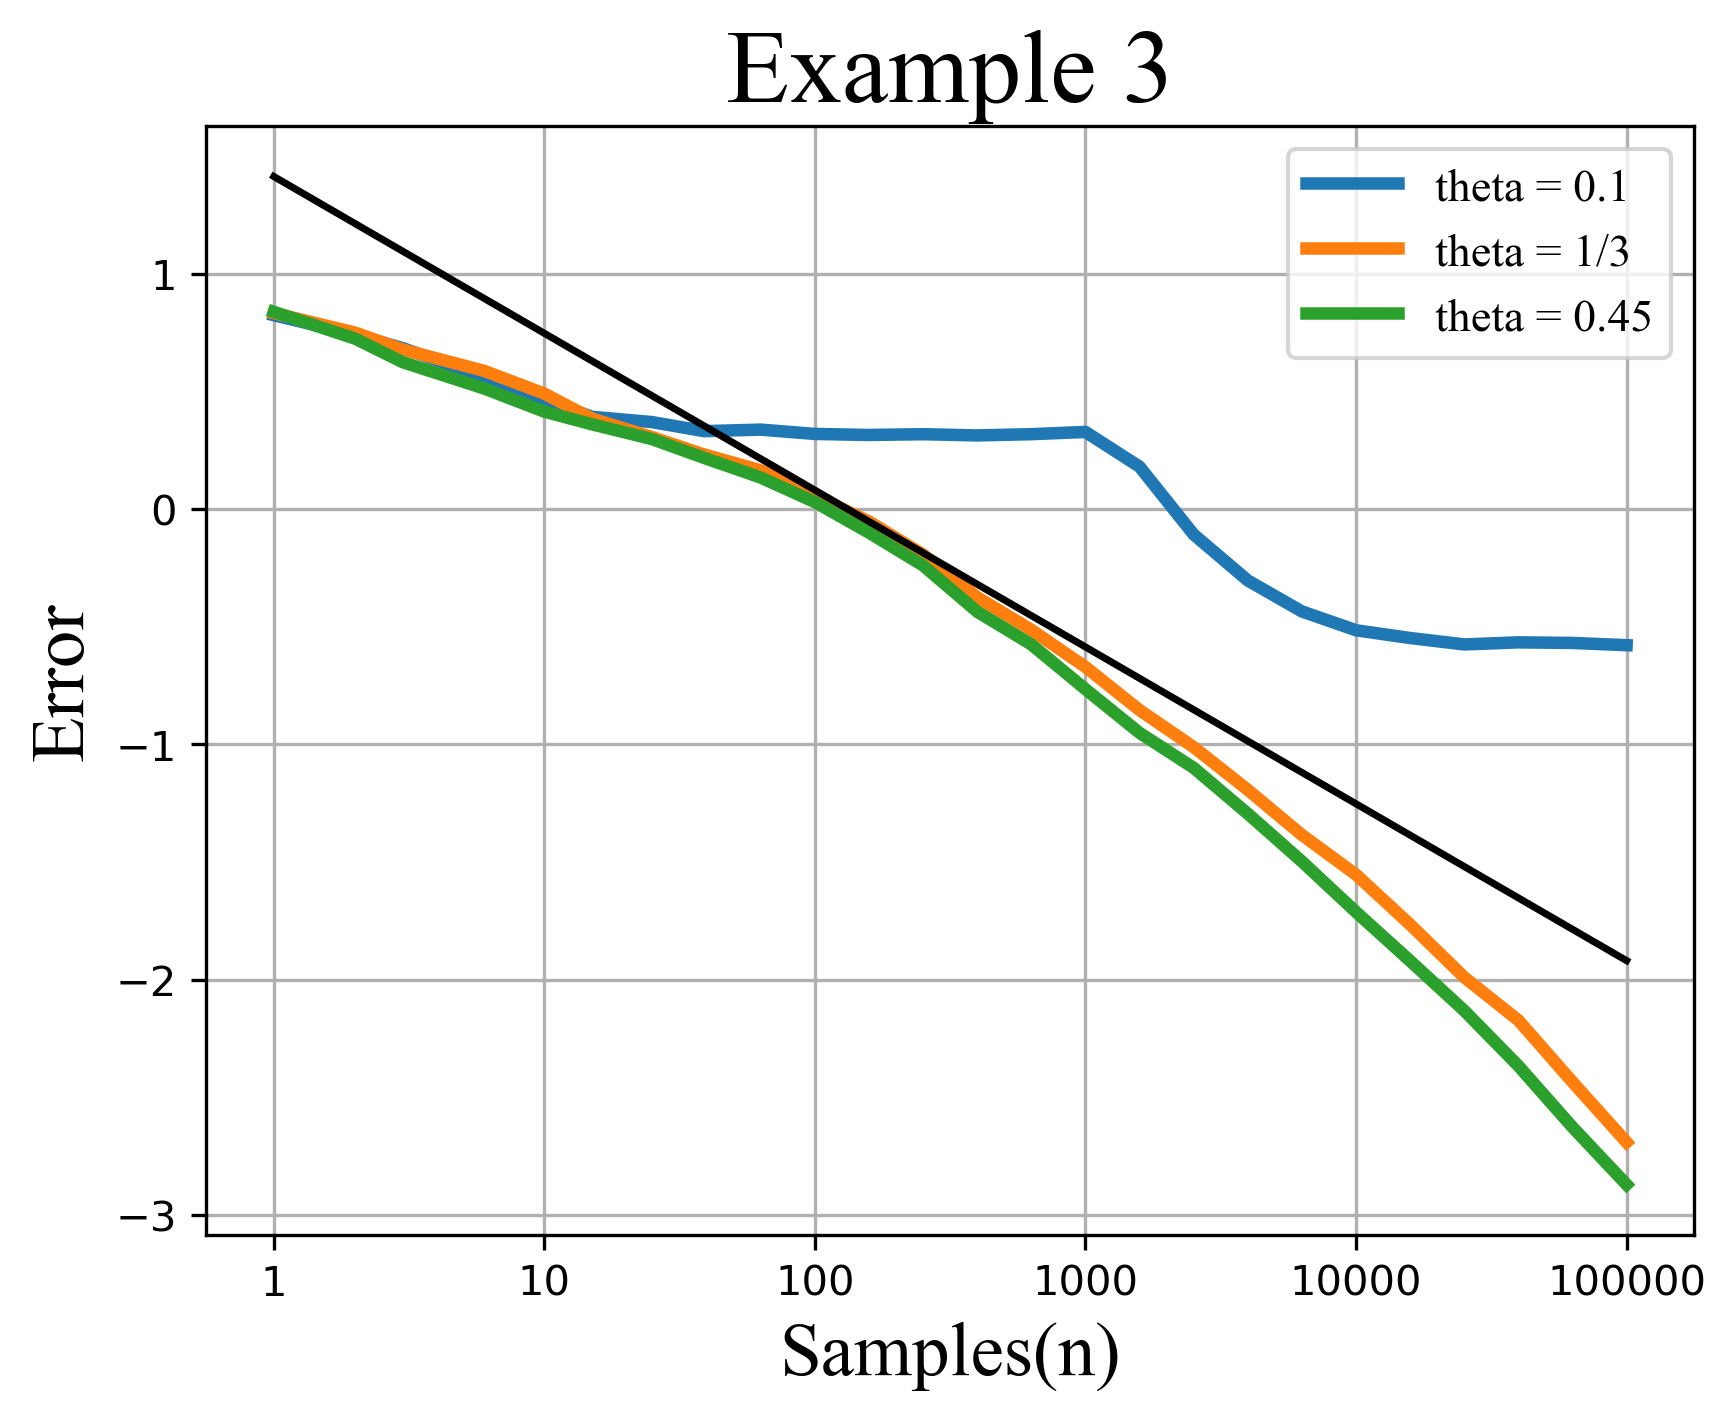

In [46]:
plt.figure(dpi=300)
Y = [log10(ERROR_example3[1])[10]-(2/3)*(i-X[10]) for i in X]
plt.plot(X, log10(ERROR_example3[0]), label='theta = 0.1',linewidth =3.0,color='#1f77b4')
plt.plot(X, log10(ERROR_example3[1]), label='theta = 1/3',linewidth =3.0,color = '#ff7f0e')
plt.plot(X, log10(ERROR_example3[2]), label='theta = 0.45',linewidth =3.0,color='#2ca02c')
plt.plot(X, Y,linewidth =1.7,color = 'black')
plt.xticks(np.array([0,1,2,3,4,5]),[1,10,100,1000,10000,100000])
plt.xlabel('Samples(n)',font={'family':'Times New Roman', 'size':18})
plt.ylabel('Error',font={'family':'Times New Roman', 'size':18})
plt.title('Example 3', font={'family':'Times New Roman', 'size':25})
font1 = {'family' : 'Times New Roman',
'weight': 'normal',
'size' : 11,
}
plt.grid()
plt.legend(prop=font1)
fig = plt.gcf()
fig.savefig('example_3.png')
plt.show()

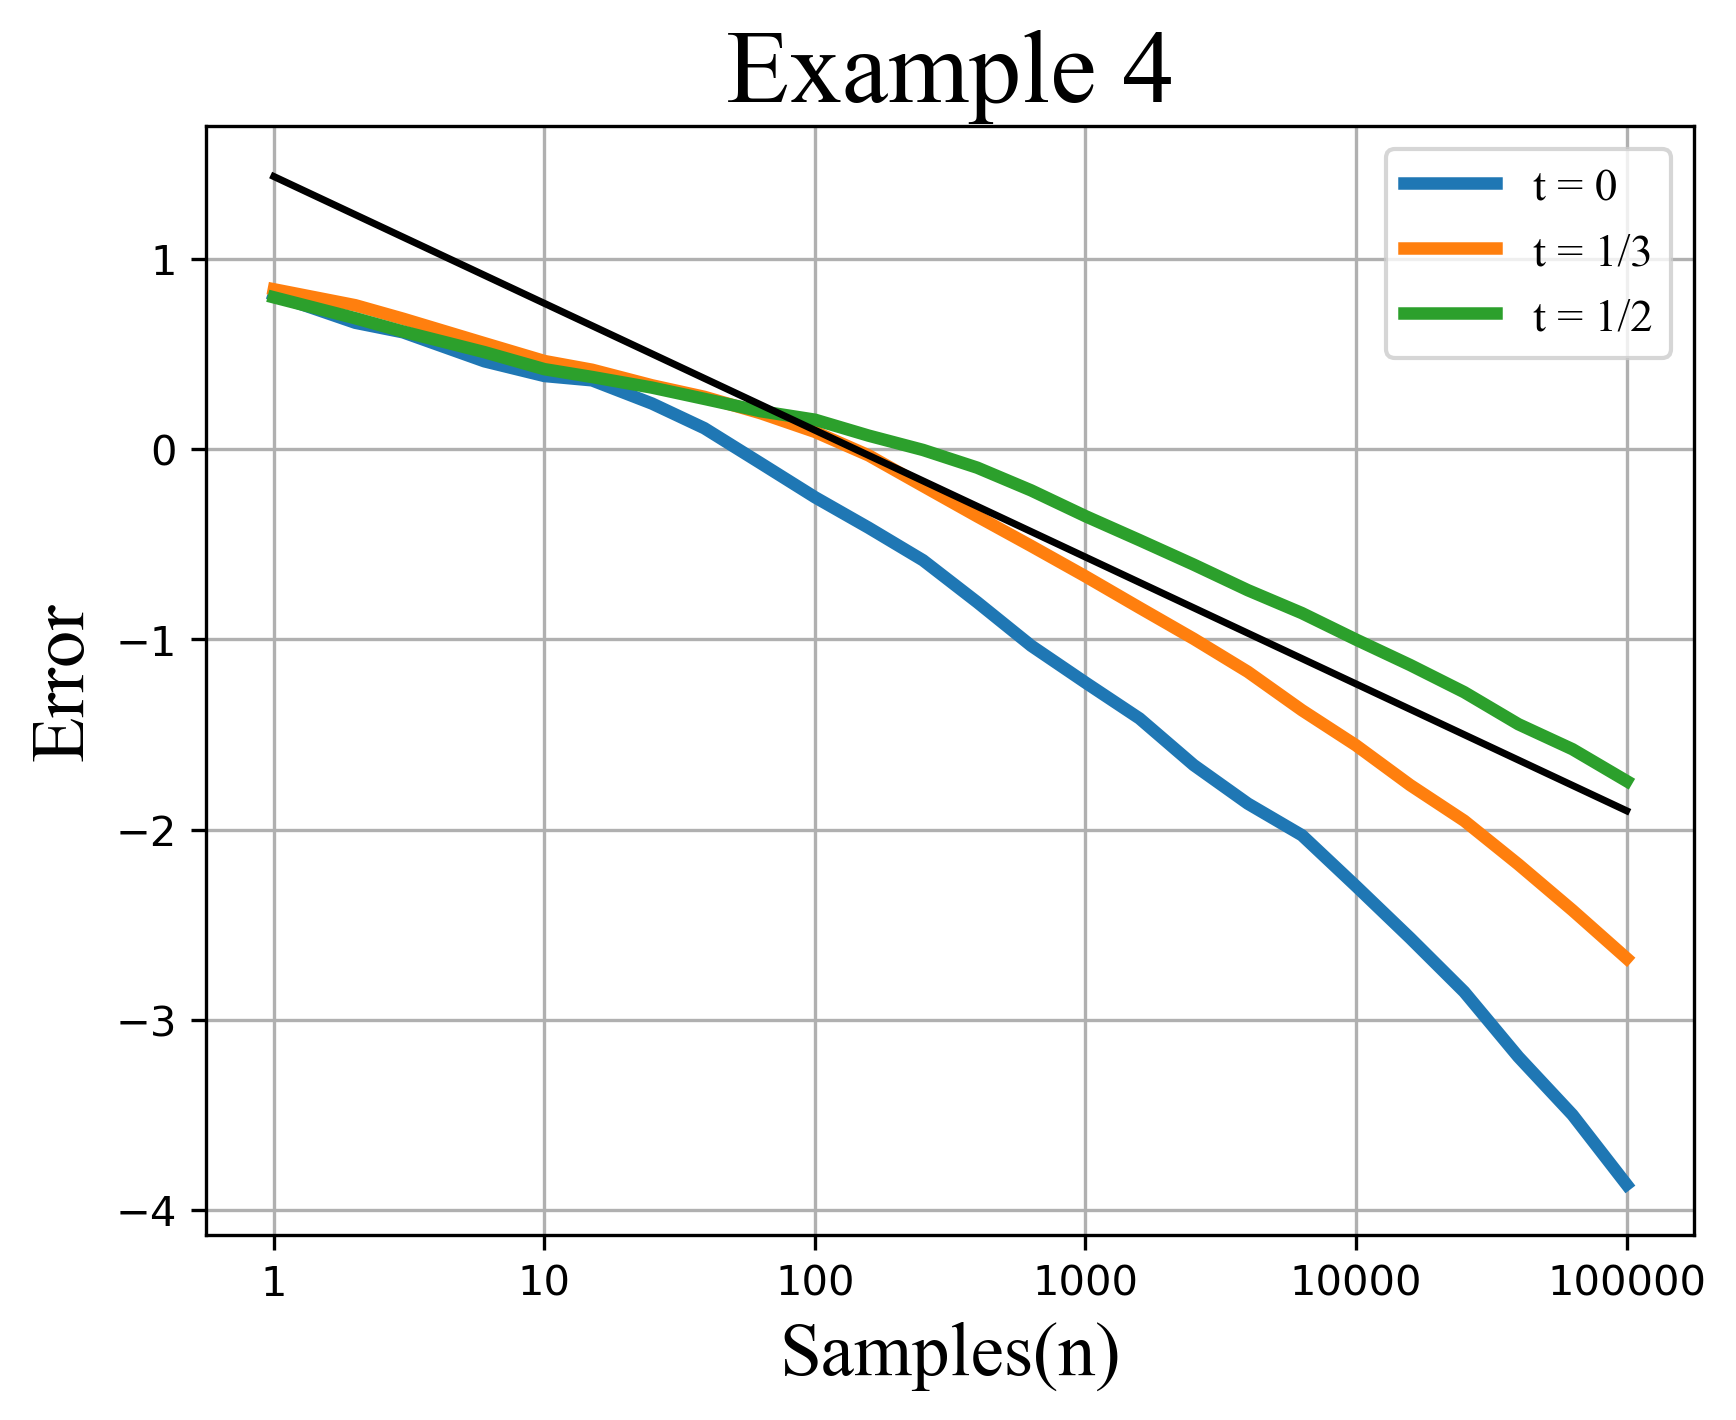

In [49]:
plt.figure(dpi=300)
Y = [log10(ERROR_example4[1])[10]-(2/3)*(i-X[10]) for i in X]
plt.plot(X, log10(ERROR_example4[0]), label='t = 0',linewidth =3.0,color='#1f77b4')
plt.plot(X, log10(ERROR_example4[1]), label='t = 1/3',linewidth =3.0,color = '#ff7f0e')
plt.plot(X, log10(ERROR_example4[2]), label='t = 1/2',linewidth =3.0,color='#2ca02c')
plt.plot(X, Y,linewidth =1.7,color = 'black')
plt.xticks(np.array([0,1,2,3,4,5]),[1,10,100,1000,10000,100000])
plt.xlabel('Samples(n)',font={'family':'Times New Roman', 'size':18})
plt.ylabel('Error',font={'family':'Times New Roman', 'size':18})
plt.title('Example 4', font={'family':'Times New Roman', 'size':25})
font1 = {'family' : 'Times New Roman',
'weight': 'normal',
'size' : 11,
}
plt.grid()
plt.legend(prop=font1)
fig = plt.gcf()
fig.savefig('example_4.png')
plt.show()

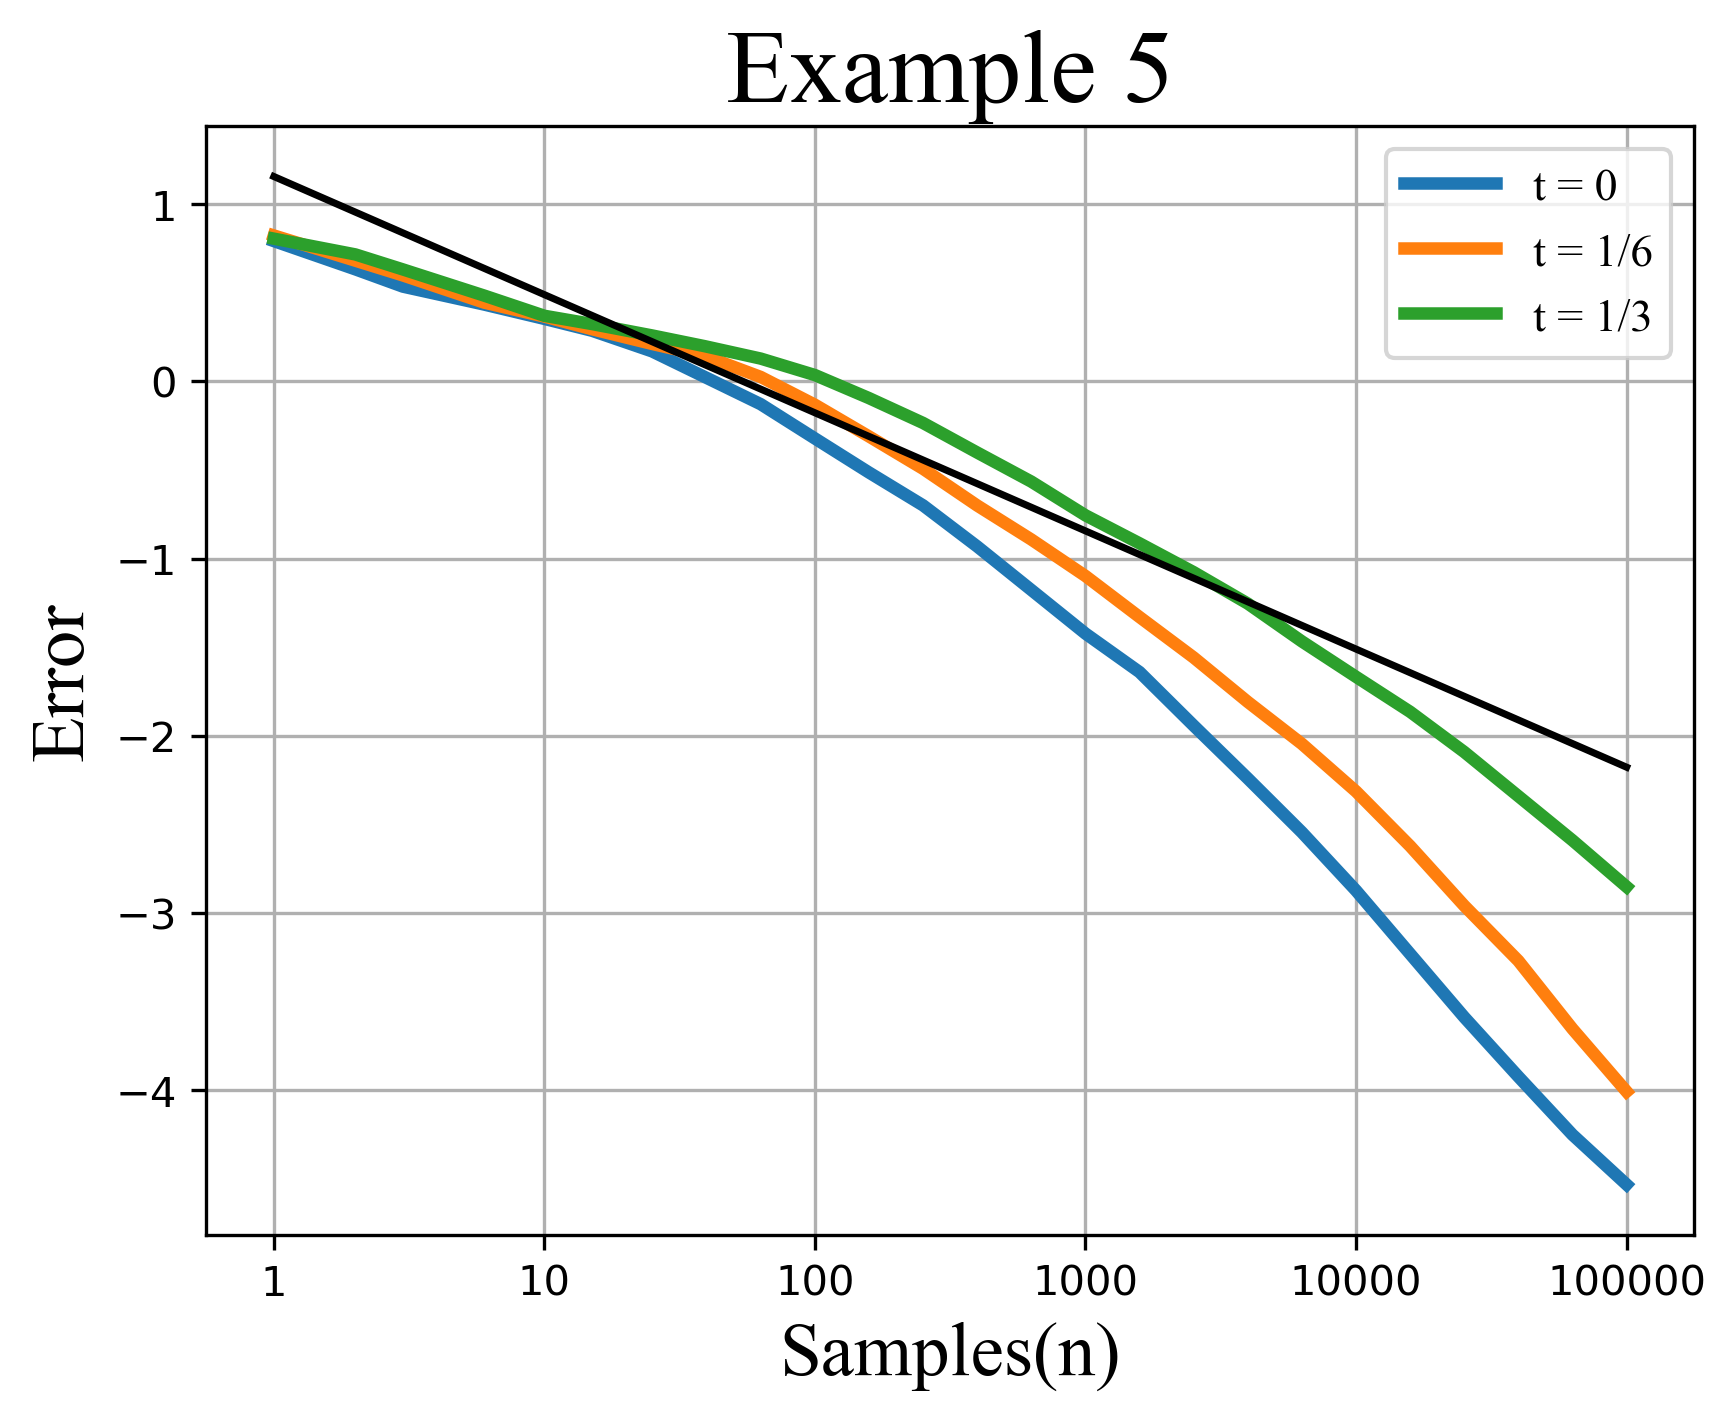

In [50]:
plt.figure(dpi=300)
Y = [log10(ERROR_example5[1])[10]-(2/3)*(i-X[10]) for i in X]
plt.plot(X, log10(ERROR_example5[0]), label='t = 0',linewidth =3.0,color='#1f77b4')
plt.plot(X, log10(ERROR_example5[1]), label='t = 1/6',linewidth =3.0,color = '#ff7f0e')
plt.plot(X, log10(ERROR_example5[2]), label='t = 1/3',linewidth =3.0,color='#2ca02c')
plt.plot(X, Y,linewidth =1.7,color = 'black')
plt.xticks(np.array([0,1,2,3,4,5]),[1,10,100,1000,10000,100000])
plt.xlabel('Samples(n)',font={'family':'Times New Roman', 'size':18})
plt.ylabel('Error',font={'family':'Times New Roman', 'size':18})
plt.title('Example 5', font={'family':'Times New Roman', 'size':25})
font1 = {'family' : 'Times New Roman',
'weight': 'normal',
'size' : 11,
}
plt.grid()
plt.legend(prop=font1)
fig = plt.gcf()
fig.savefig('example_5.png')
plt.show()

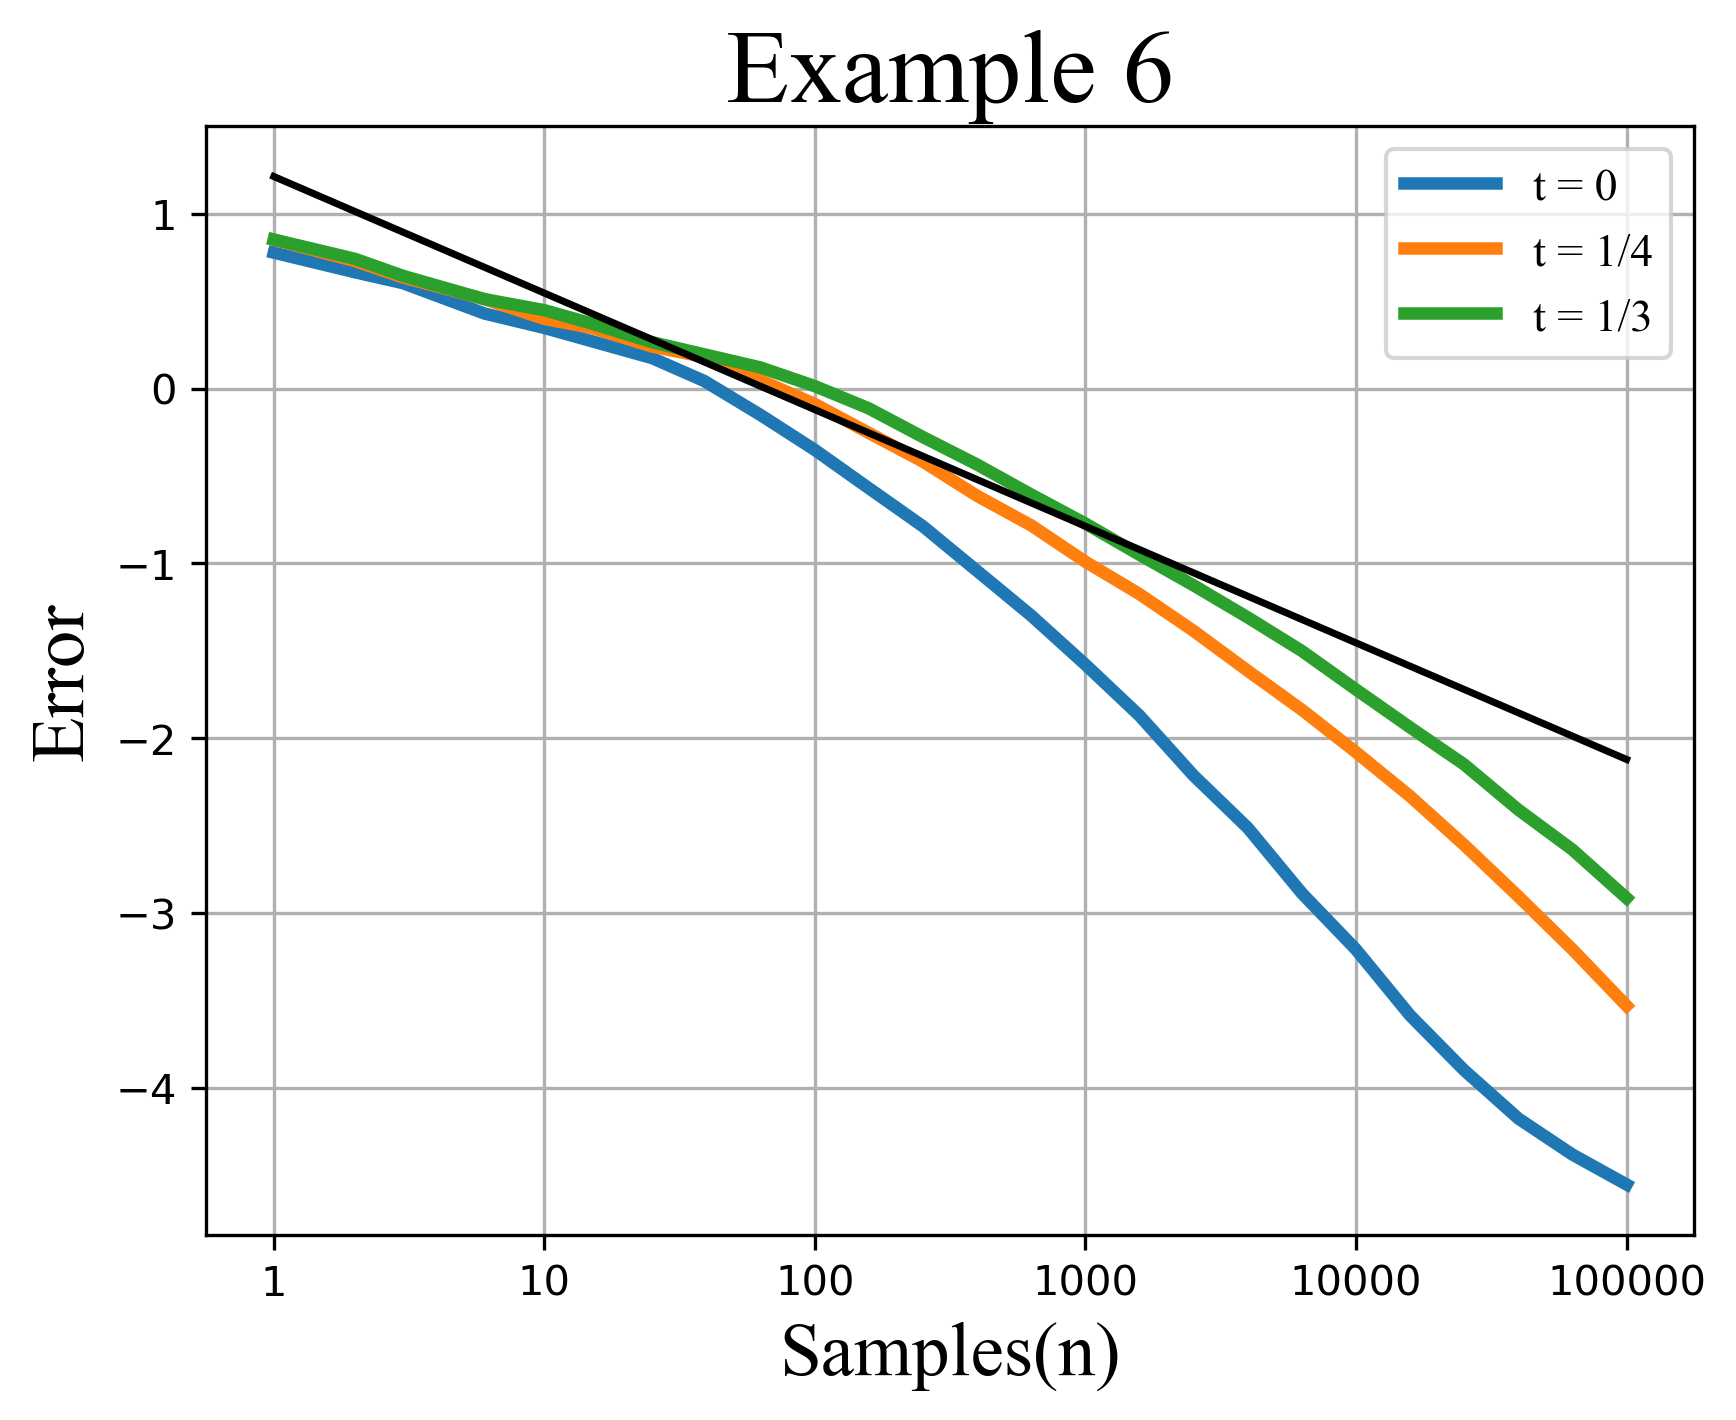

In [51]:
plt.figure(dpi=300)
Y = [log10(ERROR_example6[1])[10]-(2/3)*(i-X[10]) for i in X]
plt.plot(X, log10(ERROR_example6[0]), label='t = 0',linewidth =3.0,color='#1f77b4')
plt.plot(X, log10(ERROR_example6[1]), label='t = 1/4',linewidth =3.0,color = '#ff7f0e')
plt.plot(X, log10(ERROR_example6[2]), label='t = 1/3',linewidth =3.0,color='#2ca02c')
plt.plot(X, Y,linewidth =1.7,color = 'black')
plt.xticks(np.array([0,1,2,3,4,5]),[1,10,100,1000,10000,100000])
plt.xlabel('Samples(n)',font={'family':'Times New Roman', 'size':18})
plt.ylabel('Error',font={'family':'Times New Roman', 'size':18})
plt.title('Example 6', font={'family':'Times New Roman', 'size':25})
font1 = {'family' : 'Times New Roman',
'weight': 'normal',
'size' : 11,
}
plt.grid()
plt.legend(prop=font1)
fig = plt.gcf()
fig.savefig('example_6.png')
plt.show()